# Rethinking data access: ECoG signal analysis over many, many files

Michael Nolan

Created: 2020.09.04.1948
Updated: 2020.09.09.1939

I intend for this to become a blog post, eventually. I'll put it up on my github.io page. Should I buy a personal domain?

## Outline
- Problem
- Data
    - structure
    - Filters + Masks
- Class structure
    - Files
        - Sampler
    - Dataset
    - Dataloader
        - multiprocessing for parallelized batching

### Problem
I'm trying to train a neural network to predict time series data (more on that in a later post). I need to access the data in order to do that. I've had some success accessing individual files in the past, loading the entire file's data into memory all at once. I can easily take that file and create a `torch.util.data.Dataset` from it, but that's not too scalable when files are ~2GB a piece and I'm working with 40+ files.

Previously I approached this problem by creating a dataset class that directly interfaced with the file with an unrefactored reading method. It is a little hacky, but works well for a single file. I also created a multifile class that can sample fixed-length sequences from a number of different data files through a single class interface. However, this is generally inflexible to different file types (I've created a few different pre-filtered versions of the same data) and gets the scope of file information (number of samples, channels, size of batch reads) spread across several class levels. I'd like a better interface to the data that's more flexible between different file encodings and 

### Solution
Classes all the way down. This requires stable and trackable access to data distributed over many many files. I think it makes sense to make a file class that holds data file, mask and channel information in an accessible form. All data loading will be through object instances of that class. A dataset class will then be made that is constructed from a collection of data file objects. This dataset will be very flexible w.r.t. sample sizes, allowing us to make arbitrary dataloaders to ease hyperparameter sweeps.

Anywho, let's go for it!

In [ ]:
# needed for class defs
import numpy as np
import scipy as sp
import os.path as path # may need to build a switch here for PC/POSIX
import glob
import re
import json
import pickle as pkl
from torch.utils.data import dataset, IterableDataset
import bisect

# not needed for class defs
import matplotlib.pyplot as plt

## Datafile Class: an simple, single interface to a structured binary datafile

In [ ]:
# this is the file interface class. 
# - It will grab everything there is to know about the data file itself and it's supporting files (mask, experiment)
#   - Channel count
#   - Channel labels
#   - Filtering information
#   - Sampling rate
#   - Sample count (recording length)
# - It will provide a clean interface for reading data from arbitrary time points
#   - the argumentless call will read all data from the file
#   - arguments will change read start point and read length
#   - arguments will change the channels returned (masked v. full)
#   - arguments will toggle data masking (nan-pack recording)
class DataFile():

    def __init__(self, data_file_path, exp_file_path=None, mask_file_path=None):

        # parse file directory and components
        data_dir = path.dirname(data_file_path)
        data_basename = path.basename(data_file_path)
        rec_id, device_id, rec_type, data_ext = data_basename.split('.')

        # experiment data file: construct and load
        if not exp_file_path:
            exp_file_name = rec_id + 'experiment.json'
            exp_file_path = path.join(data_dir,exp_file_name)

        # mask file: construct and load
        if not mask_file_path:
            mask_file_name = rec_id + '.' + device_id + '.' + rec_type + '.mask.pkl'
            mask_file_path = path.join(data_dir,mask_file_name)
         
        # set recording parameters
        self.set_data_parameters(data_file_path,exp_file_path,mask_file_path)

    # this is returned when the print() command is called.
    def __repr__(self):
        path_repr_str = f'Data file object: {self.data_file_path}'
        sample_repr_str = f'\tsamples: {self.n_sample} ({self.n_sample/self.srate:0.2f}s, {self.data_mask.mean()*100:0.2f}% masked)'
        ch_repr_str = f'\tchannels: {self.n_ch} ({self.ch_idx.mean()*100:0.2f}% masked)'
        return path_repr_str + '\n' + sample_repr_str + '\n' + ch_repr_str + '\n'
                

    # read data segment. Default call (no arguments) returns the entire recording.
    def read( self, t_start=0, t_len=-1, ch_idx=None, use_mask=True, mask_value=0., mask_pad_t=5 ):

        # get offset sample/byte values
        n_offset_samples = int(round(t_start * self.srate))
        n_offset_items = n_offset_samples * self.n_ch
        n_offset_bytes = n_offset_items * self.data_type().nbytes
        if t_len == -1:
            n_read_items = t_len
            n_read_samples = int(self.n_sample)
        else:
            n_read_samples = int(t_len * self.srate)
            n_read_items = n_read_samples * self.n_ch
        
        # read data
        with open(self.data_file_path,'rb') as f:
            data = np.fromfile(f,self.data_type,count=n_read_items,offset=n_offset_bytes).reshape(n_read_samples,self.n_ch).T

        # remove channels
        if not ch_idx:
            ch_idx = ~self.ch_idx
        data = data[ch_idx,:] # mask values are True for bad spots

        # mask data
        sample_idx = np.arange(n_offset_samples,n_offset_samples+n_read_samples)
        data[:,self.data_mask[sample_idx]] = mask_value

        # consider: time array? May not want to incorporate until global time is added
        return data


    # compute data parameter values and add as object attributes
    def set_data_parameters( self, data_file_path, exp_file_path, mask_file_path ):
        # parse file
        data_file = os.path.basename(data_file_path)
        data_file_kern = os.path.splitext(data_file)[0]
        rec_id, microdrive_name, rec_type = data_file_kern.split('.')
        data_path = os.path.dirname(data_file_path)
        
        # read experiment file
        exp_file = os.path.join(data_path,rec_id + ".experiment.json")
        with open(exp_file,'r') as f:
            exp_dict = json.load(f)
        
        # get microdrive parameters
        microdrive_name_list = [md['name'] for md in exp_dict['hardware']['microdrive']]
        microdrive_idx = [md_idx for md_idx, md in enumerate(microdrive_name_list) if microdrive_name == md][0]
        microdrive_dict = exp_dict['hardware']['microdrive'][microdrive_idx]
        electrode_label_list = [e['label'] for e in exp_dict['hardware']['microdrive'][0]['electrodes']]
        n_ch = len(electrode_label_list)
        
        # get srate
        if rec_type == 'raw':
            srate = exp_dict['hardware']['acquisition']['samplingrate']
            data_type = np.ushort
        elif rec_type == 'lfp':
            srate = 1000
            data_type = np.float32
        elif rec_type == 'clfp':
            srate = 1000
            data_type = np.float32
        
        # read mask
        ecog_mask_file = os.path.join(data_path,data_file_kern + ".mask.pkl")
        with open(ecog_mask_file,"rb") as mask_f:
            mask = pkl.load(mask_f)
        # data_mask = grow_bool_array(mask["hf"] | mask["sat"], growth_size=int(srate*0.5))
        data_mask = mask["hf"] | mask["sat"]
        if 'ch' in mask.keys():
            ch_idx = mask['ch']
        else:
            ch_idx = np.arange(n_ch)

        # clean channel labels - formatting can change from recording to recording. Get Channel ID from full string.
        ch_label_pattern = r'E\d+'
        ch_label_cleaned = [re.findall(ch_label_pattern,ch_l)[0] for ch_l in electrode_label_list]
        
        # set parameters
        self.data_file_path = data_file_path
        self.exp_file_path = exp_file_path
        self.mask_file_path = mask_file_path
        self.rec_id = rec_id
        self.microdrive_name = microdrive_name
        self.rec_type = rec_type
        self.srate = srate
        self.data_type = data_type
        self.data_mask = data_mask
        self.n_ch = n_ch
        self.ch_idx = ch_idx
        self.ch_labels = ch_label_cleaned

        # set sample length information
        self.n_sample = len(self.data_mask)
        self.t_total = self.n_sample/self.srate # (s)

# morphological transform: expand boolean array values a set distance from all current True values.
# this is used to spread out mask estimates to more conservatively filter data files.
# def grow_bool_array( in_bool_array, growth_size=50):
#     mask_true_idx = np.arange(len(in_bool_array))[in_bool_array]
#     out_bool_array = in_bool_array.copy()
#     for seed_idx in mask_true_idx:
#         start_idx = np.max((0,seed_idx-growth_size))
#         stop_idx = np.min((len(mask_true_idx)-1,seed_idx+growth_size))
#         on_range_idx = np.arange(start_idx,stop_idx)
#         out_bool_array[on_range_idx] = True
    
#     return out_bool_array


That should do the trick! Let's build a tester to see how it works:

In [ ]:
# test class instance for the first recording in the dataset:
data_file_path = "E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\001\\rec001.LM1_ECOG_3.clfp.dat"
datafile = DataFile(data_file_path)
print(datafile)
t_start = 7000
t_len = 1
data_sample = datafile.read(t_start=t_start,t_len=t_len)
plt.plot(data_sample[11,:]);
plt.xlabel('time (s)')
plt.ylabel('amplitude ($\mu$V)')
plt.title('Sample data segment')
plt.savefig('ecog_sample.png')

! It works great. I even added a nice `self.__repr__()` method to format its output when passed to python's `print` function. 

Now let's get a sense of the read speeds. I'll repeat the `datafile.read()` call with random time points 1000 times and get some statistics on average loading time.

In [ ]:
import time
n_iter = 1000
t_len = 1
t_iter = np.zeros(n_iter)
for k in range(n_iter):
    t_start = np.random.rand()*(datafile.t_total-t_len)
    t = time.time()
    data = datafile.read(t_start=t_start,t_len=t_len)
    t_iter[k] = time.time()-t
print(f'{n_iter} data pulls complete.')

In [ ]:
plt.hist(t_iter,100,label='read times');
plt.axvline(t_iter.mean(),color='r',label='mean')
plt.xscale('linear')
plt.xlabel('Read time (s)')
plt.ylabel('sample frequency')
plt.title('1s sample read time distribution - DataFile class')
plt.legend(loc=0)
print(f'Mean read time: {t_iter.mean():0.3E}')
print(f'Total read time ({n_iter} reads): {t_iter.sum():0.3E}')
plt.savefig('read_time_hist.png')

Neat! I'm unsure of what's causing the split distribution in read times here, but we're getting a very, very fast read speed for >80% of draws. 

The total batch read time is 0.16s. If we're to use this as the data access API for a pytorch dataloader, we might want something faster. This file is currently on an SSD connected to my computer through a USBC/3.0 port. Moving all of this data to my system's internal memory may provide me with an immediate speed-up, [provided that I use my PCIe SSD.](https://www.unbxtech.com/2019/03/pcie-sata-usb-interfaces-explained.html). Using different data reading methods to optimize the code [may not lead to much significant improvement, so I'll leave them be for now.](http://rabexc.org/posts/io-performance-in-python).

Either way, it all works great! This will make the next step a bit easier: creating a dataset interface to a list of these DataFile objects.

This design will take advantage of the `ConcatDataset` construction [provided by pytorch](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#ConcatDataset), which allows for the clean concatenation of individual dataset objects. A single dataloader can be constructed from this `ConcatDataset` instance to divide train/test partitions. The `__getitem__()` method will return source and target samples for our sequence prediction model. To allow the `__len__()` method to accurately represent the number of src/trg pairs that a file can produce without overlapping on a masked value, we will have to create an dataset for each file with a fixed src/trg sequence length. I plan to test many different pairs of these lengths, so I'll wrap this up by writing a generator function that can go all the way from a list of structured binary data files to a single `ConcatDataset`. That will make hyperparameter sweeps a lot simpler.

Let's start by making a list of these datafile objects:

In [ ]:
data_file_list = glob.glob("E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\*\\*.clfp.dat")
print(f'{len(data_file_list)} files found!')

datafile_list = [DataFile(fp) for fp in data_file_list]
print(datafile_list)

A hop, skip and a glob away and we have a list of files! The Datafile class is then easily created for each of these files using a tight list comprehension. We'll have to make a dataset object for each of the elements in this list, but this provides a nice look into the channel mismatches we'll have to deal with when concatenating the individual datasets. Each datafile is masked at a different percentage of masked channels. Also, each datafile may be masking different channels than every other file. Getting the intersection of all labels will be key.

## DatafileDataset class: a pytorch interface to the Datafile class API

In [ ]:
# Time Series Dataset class!

# This class with inherit the pytorch Dataset class methods. It will overwrite the `__init__()`, `__len__()` and `__getitem__()` methods to create and embed information about what can be sampled from these files while avoiding masked regions and while only drawing from a unified list of electrodes.
import torch
from torch.utils.data import Dataset
class DatafileDataset(Dataset):

    def __init__( self, datafile, src_t, trg_t, step_t, transform=None ):
        assert (isinstance(datafile, DataFile) or path.exists(datafile)), 'first argument must be DataFile object or valid path string'
        if isinstance(datafile, str):
            datafile = DataFile(datafile)
        sample_t = src_t + trg_t
        src_len = round(src_t*datafile.srate)
        trg_len = round(trg_t*datafile.srate)
        step_len = round(step_t*datafile.srate)
        sample_len = round(sample_t*datafile.srate)
        sample_start_idx = np.arange(0,datafile.n_sample-sample_len,step_len) # all candidate starting indices
        sample_start_idx_in_mask = [np.any(datafile.data_mask[s_s_idx:s_s_idx+sample_len]) for s_s_idx in sample_start_idx] # sample window is masked
        sample_start_idx = sample_start_idx[np.logical_not(sample_start_idx_in_mask)] # remove masked starting indices
        sample_start_t = sample_start_idx/datafile.srate

        self.datafile = datafile
        self.src_len = src_len
        self.trg_len = trg_len
        self.step_len = step_len
        self.sample_len = sample_len
        self.src_t = src_t
        self.trg_t = trg_t
        self.step_t = step_t
        self.sample_t = sample_t
        self.sample_start_idx = sample_start_idx
        self.sample_start_t = sample_start_t
        self.transform = transform

    def __len__( self ):
        return len(self.sample_start_idx)

    def __getitem__( self, idx, ch_idx=None ):
        sample = self.datafile.read(t_start=self.sample_start_t[idx],t_len=self.sample_t,ch_idx=ch_idx)
        src = sample[:,:self.src_len]
        trg = sample[:,self.src_len:]
        if self.transform:
            src = self.transform(src)
            trg = self.transform(trg)
        return src, trg
        

In [ ]:
# let's test one out!
test_dfds = DatafileDataset(datafile,src_t=1,trg_t=1,step_t=0.5)
print(test_dfds)
print(f'number of samples: {len(test_dfds)}')
src, trg = test_dfds.__getitem__(10)
t_src = np.arange(test_dfds.src_len)/test_dfds.datafile.srate
t_trg = np.arange(test_dfds.src_len,test_dfds.sample_len)/test_dfds.datafile.srate
plt.plot(t_src,src[11,:],'b',label='src')
plt.plot(t_trg,trg[11,:],'r',label='trg')
plt.legend(loc=0)
plt.xlabel('time (s)')
plt.ylabel('amp. ($\mu$V)')
plt.title('Datafile Dataset __getitem__() output')

Nice! It works. Now let's create a list of these DatafileDataset objects:

In [ ]:
src_t = 1.0
trg_t = 1.0
step_t = 2.0
DatafileDatasetList = [DatafileDataset(df,src_t,trg_t,step_t) for df in data_file_list]
print(DatafileDatasetList)

Again, it all works great. I'm starting to like Python! Now let's try creating a janky, uninformed version of our smarter concatenated dataset (to come):

In [ ]:
from torch.utils.data import ConcatDataset
DatafileConcatDataset = ConcatDataset(DatafileDatasetList)
dfds_samples = [df.__len__() for df in DatafileDatasetList]
print(f'samples in each DatafileDataset: {dfds_samples}.sum() = {sum(dfds_samples)}')
print(f'samples in DatafileConcatDataset: {DatafileConcatDataset.__len__()}')

src, trg = DatafileConcatDataset.__getitem__(30500)
t_src = np.arange(test_dfds.src_len)/test_dfds.datafile.srate
t_trg = np.arange(test_dfds.src_len,test_dfds.sample_len)/test_dfds.datafile.srate
plt.plot(t_src,src[11,:],'b',label='src')
plt.plot(t_trg,trg[11,:],'r',label='trg')
plt.legend(loc=0)
plt.xlabel('time (s)')
plt.ylabel('amp. ($\mu$V)')
plt.title('DatafileConcatDataset __getitem__() output')

There we go! It works! It all works - a nice interface to draw samples from a collection of files. You can keep that same list of files and reuse it over and over, or use the same list of Datafile objects, to create however many sample size datasets as you need. Easy-peasy!

Let's profile the reading times a little bit. A very real use-case will be running though the entire dataset for a training/testing epoch. I'm not sure how pytorch engineers their batch sampling, but a sequential draw of all these samples will be a useful approximation.

In [ ]:
t_iter = np.zeros(len(DatafileConcatDataset))
for sample_idx in range(len(DatafileConcatDataset)):
    t = time.time()
    src, trg = DatafileConcatDataset.__getitem__(sample_idx)
    t_iter[sample_idx] = time.time() - t


In [ ]:
plt.hist(t_iter,100,label='read times');
plt.axvline(t_iter.mean(),color='r',label='mean')
plt.xscale('linear')
plt.xlabel('Read time (s)')
plt.ylabel('sample frequency')
plt.title('1s sample read time distribution - DataFile class')
plt.legend(loc=0)
print(f'Mean read time: {t_iter.mean():0.3E}')
print(f'Total read time ({n_iter} reads): {t_iter.sum():0.3E}')
plt.savefig('read_time_hist.png')

Oh no! It doesn't work quite as well with all of this. I can't imagine that the class infrastructure is causing this diversity of read times. I'll have to retry this a little later with data copied to my local drive.

Other than that, everything is working pretty well. I don't know how this is impacted by GPU use, but it will most likely slow things down.

Anywho: using the classes above, we can go from 0-dataset with the following:

In [ ]:
data_file_list = glob.glob("E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\18032*\\*\\*ECOG*.clfp.dat")
src_t = 1.0
trg_t = 1.0
step_t = 2.0
datafile_concatdataset = ConcatDataset([DatafileDataset(df,src_t,trg_t,step_t) for df in data_file_list])

Isn't that slick? 6 lines!

...but we aren't done. We need to extend the ConcatDataset to align channel indices between datafile objects. Let's do that with an almost-carbon copy of the original ConcatDataset, but with some added machinery and alignment in the __init__() and __getitem__() methods. The channel alignment will work like this:
- Get the intersection of all channels (based on label) present in all DatafileDatasets in the DatafileConcatDataset
- For each DatafileDataset $d$:
    - samples drawn from these datasets will be masked by the default `datafile.read()` behavior. This is a superset of the intersection and needs to be subsampled.
    - the masked channel label list for $d$ is then aligned to the elements in the intersection to get a secondary mask of integer values
    - secondary mask is assigned as the $i_d$ element in the DatafileConcatDataset.ch_idx attribute

The `__getitem__()` method is then augmented to use this indexing.

In [ ]:
class DatafileConcatDataset(Dataset):
    r"""Dataset as a concatenation of multiple datafile datasets.

    This class is useful to assemble different existing datafile datasets and draw from the channel indices that they share.

    Arguments:
        datasets (sequence): List of datafile datasets to be concatenated
    """

    @staticmethod
    def cumsum(sequence):
        r, s = [], 0
        for e in sequence:
            l = len(e)
            r.append(l + s)
            s += l
        return r

    def __init__(self, datasets):
        super(DatafileConcatDataset, self).__init__()
        assert len(datasets) > 0, 'datasets should not be an empty iterable'
        self.datasets = list(datasets)
        for d in self.datasets:
            assert not isinstance(d, IterableDataset), "ConcatDataset does not support IterableDataset"
        self.cumulative_sizes = self.cumsum(self.datasets)
        # get intersection of channel labels present in each dataset in self.datasets
        file_labels = []
        for d in self.datasets:
            file_mask_idx = np.arange(d.datafile.n_ch)[~d.datafile.ch_idx] # idx of unmasked channels in this file
            file_labels.append(np.array(d.datafile.ch_labels)[file_mask_idx])
        self.ch_label = list(set(file_labels[0]).intersection(*file_labels))
        # get index list of intersection channel locations in each datafile
        ch_sample_idx_list = []
        for d in self.datasets:
            dataset_ch_sample_idx_list = []
            for ch_i_l in self.ch_label:
                dataset_ch_sample_idx_list.append(list(np.array(d.datafile.ch_labels)[~np.array(d.datafile.ch_idx)]).index(ch_i_l))
            ch_sample_idx_list.append(dataset_ch_sample_idx_list)
        self.ch_idx = ch_sample_idx_list
        self.n_ch = len(ch_label)

    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, idx):
        if idx < 0:
            if -idx > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            idx = len(self) + idx
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, idx)
        if dataset_idx == 0:
            sample_idx = idx
        else:
            sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]
        src, trg = self.datasets[dataset_idx].__getitem__(sample_idx)
        src = src[self.ch_idx[dataset_idx],:]
        trg = trg[self.ch_idx[dataset_idx],:]
        return (src, trg)

    @property
    def cummulative_sizes(self):
        warnings.warn("cummulative_sizes attribute is renamed to "
                      "cumulative_sizes", DeprecationWarning, stacklevel=2)
        return self.cumulative_sizes

Here we can see two major augmentations to the ConcatDataset class: the definition of `self.ch_label`, `self.ch_idx` and the augmentation of `self.__getitem__(...)`. The first two find the intersection between all available channels across all files and then aligns each datafile dataset's outputs to that set intersection. This makes each sample drawn from this dataset represent the same channels, which allows a single model to be trained on the entire dataset with a coherent channel map.

In [ ]:
data_file_list = glob.glob("E:\\aoLab\\Data\\WirelessData\\Goose_Multiscale_M1\\180325\\*\\*.clfp.dat")
src_t = 1.0
trg_t = 1.0
step_t = 0.5
datafile_concatdataset = DatafileConcatDataset([DatafileDataset(df,src_t,trg_t,step_t) for df in data_file_list])

Mean read time: 2.455E-04
Total read time (128302 reads): 3.150E+01


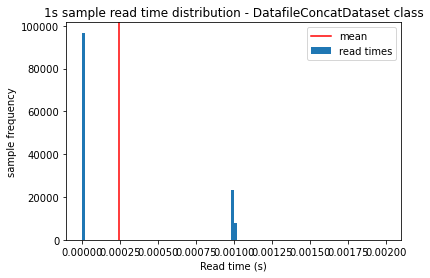

In [43]:
# one last time, let's look at the sampling rate:
n_iter = len(datafile_concatdataset)
t_iter = np.zeros(n_iter)
for n in range(n_iter):
    t = time.time()
    src, trg = datafile_concatdataset.__getitem__(n)
    t_iter[n] = time.time() - t
plt.hist(t_iter,100,label='read times');
plt.axvline(t_iter.mean(),color='r',label='mean')
plt.xscale('linear')
plt.xlabel('Read time (s)')
plt.ylabel('sample frequency')
plt.title('1s sample read time distribution - DatafileConcatDataset class')
plt.legend(loc=0)
print(f'Mean read time: {t_iter.mean():0.3E}')
print(f'Total read time ({n_iter} reads): {t_iter.sum():0.3E}')
# plt.savefig('read_time_hist.png')

So there you go! A set of classes (only 3) to convert a collection of data files into a single pytorch dataset. They all draw from the same data channels!

...but there's more work to be done. Say you have data stored in a .npz file, or a differently formatted binary file? It'd be nice to have that worked into the datafile __init__() interface. 